In [187]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [151]:
from typing import List, Optional
import importlib
from __future__ import annotations
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import polars as pl
import networkx.algorithms.bipartite as nxbp
import mylib.data_utils as mdu
import mylib.graph_utils as mgu
import mylib.plotting as mpl
import pickle
import seaborn as sns
FILTERED_DATA_PATH="./data"
GRAPH_FILE_PATH=FILTERED_DATA_PATH+"/graph.pickle"
CFG_PL_STANDARD = pl.Config(restore_defaults=True,apply_on_context_enter=True)
CFG_PL_ALL_ROWS = pl.Config(tbl_rows=-1,tbl_width_chars=-1,apply_on_context_enter=True)
CFG_PL_FULL_ROWS = pl.Config(fmt_str_lengths=9000,tbl_width_chars=-1,fmt_table_cell_list_len=-1,apply_on_context_enter=True)
CFG_PL_FULL_TABLE = pl.Config(tbl_rows=-1,fmt_str_lengths=9000,tbl_width_chars=-1,fmt_table_cell_list_len=-1,apply_on_context_enter=True)

# Analýza sítě 100 nejvýdělečnějších herců a jejich žánrů


## Cíl práce
Cílem práce je analyzovat vztahy mezi 100 nejvýdělečnějšími dosud žijícími herci na základě jejich filmové tvorby do roku 2025, vzájemných spoluprací a preferovaných žánrů. Práce se zaměřuje na určení vzdáleností mezi herci pomocí algoritmů nejkratších cest, identifikaci herců, kteří výrazně propojují ostatní, a zjištění, kteří herci mají v síti největší vliv či nejčastěji spolupracují.

Dále je cílem zjistit, jak se jednotlivé filmové žánry prolínají, které žánry tvoří přirozené mosty mezi ostatními a které mají roli centrálních nebo univerzálních žánrů. Zároveň bude zkoumáno, jak se preference žánrů vyvíjejí v čase a zda existují rozdíly mezi žánry typickými pro mladší a starší herce. Práce využije reálná data z IMDB, což umožní analyzovat skutečné filmové vazby a dlouhodobé trendy.

## Obsah
1. Použitá data
1. Načtení a filtrace dat
2. Analýza projekce herců
3. Analýza projekce žánrů
4. Shrnutí

## Použitá data

### Původ dat
Data pocházejí z veřejných datasetů IMDB (zejména *name.basics*, *title.basics*, *title.principals*) [https://developer.imdb.com/non-commercial-datasets/](https://developer.imdb.com/non-commercial-datasets/).

Nejvýděleječnějšími herci je v této práci myšleno 100 prvních herců z žebříčku serveu *The Numbers* [https://www.the-numbers.com/box-office-star-records/domestic/lifetime-acting/top-grossing-leading-stars](https://www.the-numbers.com/box-office-star-records/domestic/lifetime-acting/top-grossing-leading-stars).

Tento žebříček obsahuje filmové hvězdy seřazené podle celkových domácích tržeb všech filmů, v nichž hrály hlavní roli (včetně dabingu a animovaných filmů) na severoamerickém trhu.

### Struktura a lokace dat
Původní data by se měla nacházet ve složce './data/original_data'. Data jsou 3 soubory ve formátu tsv a jeden soubor ve formátu csv oddělený středníkem.
- title.basics.tsv ~1GB - obsahuje informace o titulech (např. film, seriál a TV pořad) a jejich žánrech
- name.basics.tsv  ~0,9GB - obsahuje informace o lidech spojených s tvorbou filmů
- title.principals.tsv ~4,2GB - obsahuje informace o pracovních pozicích, jež lidé zastávali při tvorbě filmeců
- profitable_actors.csv ~11KB - obsahuje informace o [nejvýdělečnějších hercích](#původ-dat)

## 1. Načtení a filtrace dat

In [6]:
ORIGINAL_DATA_PATH="./data/original_data"

alespoň jedním přiřazeným žánrem.  
V IMDB datasetu se nachází 279 647 odpovídajích filmů vadaných mezi lety 1896 a 2025.

### Herci

In [10]:
df_profitable_actors = mdu.load_lazy(path= ORIGINAL_DATA_PATH+"/profitable_actors_2026-1-15.csv",
                      separator=";",
                      null_values="",
                      schema={
                          "Rank":pl.UInt32,
                          "Name":pl.Utf8,
                          "DomesticBox":pl.Utf8,
                          "Office":pl.Utf8,
                          "Movies":pl.UInt32,
                          "Average":pl.Utf8,
                          "BirthYear":pl.UInt16
                      }).sort("Rank").select(["Name","BirthYear","Rank"]).rename({
                          "Name":"primaryName",
                          "BirthYear":"birthYear",
                          "Rank":"rank"
                          })


In [8]:
df_actors = mdu.load_lazy(path= ORIGINAL_DATA_PATH+"/name.basics.tsv",
                      separator="\t",
                      schema={
                          "nconst":pl.Utf8,
                          "primaryName":pl.Utf8,
                          "birthYear":pl.Int16,
                          "deathYear":pl.Int16,
                          "primaryProfession":pl.List(pl.Utf8),
                          "knownForTitles":pl.List(pl.Utf8)
                      })


### Vyhledání nejvýdělečnějších herců v IMDB datasetu
Před samotným filtrováním filmů, žánrů a herců je nutné spojení IMDB datasetu lidí s datasetem nejvýdělečnějších herců kvůli pozdějšímu propojení s ostatními datasety od IMDB.

A to na základě společných sloupců.

In [152]:
mdu.display_with_title("IMDB Herci",df_actors.head(1).collect())
mdu.display_with_title("Nejvýdělečnější herci",df_profitable_actors.head(1).collect())

nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
nm0000001,Fred Astaire,1899,1987,['actor' 'miscellaneous' 'producer'],['tt0072308' 'tt0050419' 'tt0027125' 'tt0025164']


primaryName,birthYear,rank
Samuel L. Jackson,1948,1


Společné sloupce v obou datasetech jsou pouze jméno a rok narození.
Výsledkem využití těchto sloupců ke spojení obou datasetů a odebrání mrtvých herců je níže zobrazený dataset.

In [154]:
df_actors_filtered_profitable = df_profitable_actors.lazy()\
.join(df_actors,on=["primaryName", "birthYear"], how="left")\
    .filter(pl.col("deathYear").is_null())\
        .drop("deathYear").collect()

df_actors_filtered_profitable_100 = df_actors_filtered_profitable.limit(100)

mdu.display_with_title(
    "Nejvýdělečnější dosud žijící herci dle jména a roku narození",
    df_actors_filtered_profitable_100.describe()
    )

statistic,primaryName,birthYear,rank,nconst,primaryProfession,knownForTitles
count,100,99.000000,100.000000,96,96.000000,96.000000
null_count,0,1.000000,0.000000,4,4.000000,4.000000
mean,None,1968.949495,51.630000,None,nan,nan
std,None,14.025759,29.855089,None,nan,nan
min,Adam Driver,1930.000000,1.000000,nm0000093,nan,nan
25%,None,1962.000000,26.000000,None,nan,nan
50%,None,1969.000000,53.000000,None,nan,nan
75%,None,1980.000000,77.000000,None,nan,nan
max,Zoe Saldaña,1996.000000,102.000000,nm5397459,nan,nan


Výše lze vidět, že po filtrování zde chybí 4 herci a jeden z herců nemá vyplněný rok narození, což by mohl být také důvod jeho nenalezení.

In [168]:
mdu = importlib.reload(mdu)
df_missing_profitable_actors = df_actors_filtered_profitable_100.filter(pl.col("nconst").is_null())
mdu.display_with_title("Nenalezení nejvýdělečnější herci",df_missing_profitable_actors)

primaryName,birthYear,rank,nconst,primaryProfession,knownForTitles
str,u16,u32,str,list[str],list[str]
"""Robert Downey, Jr.""",1965,3,null,null,null
"""Benedict Wong""",null,70,null,null,null
"""Mark Hamill""",1951,73,null,null,null
"""Shia LaBeouf""",1986,90,null,null,null


Výše lze vidět čtyři herce jež se nepodařilo najít dle jejich jména a roku narození.  
Chybějící herci by nemuseli mít vyplněný rok narození, proto se vyberou herci z IMDB datasetu se stejným jménem jako chybějící herci.

In [173]:
df_may_be_missing_profitable_actors = df_missing_profitable_actors.select(["primaryName","birthYear","rank"]).lazy().join(
    df_actors,
    on=["primaryName"],
    how="left"
    )
mdu.display_with_title("Potenciální kandidáti na chybějící herce",df_may_be_missing_profitable_actors.describe())

statistic,primaryName,birthYear,rank,nconst,birthYear_right,deathYear,primaryProfession,knownForTitles
str,str,f64,f64,str,f64,f64,f64,f64
"""count""","""9""",8.0,9.0,"""8""",0.0,0.0,8.0,8.0
"""null_count""","""0""",1.0,0.0,"""1""",9.0,9.0,1.0,1.0
"""mean""",null,1957.125,66.777778,null,null,null,null,null
"""std""",null,12.654051,24.621016,null,null,null,null,null
"""min""","""Benedict Wong""",1951.0,3.0,"""nm0000434""",null,null,null,null
"""25%""",null,1951.0,73.0,null,null,null,null,null
"""50%""",null,1951.0,73.0,null,null,null,null,null
"""75%""",null,1951.0,73.0,null,null,null,null,null
"""max""","""Shia LaBeouf""",1986.0,90.0,"""nm8305492""",null,null,null,null


Z výše uvedené tabulky lze zjistit, že je zde osm herců (počet vyplněných "nconst") jejichž jména se shodují se třemi chybějícími herci (jeden nebyl nalezen - počet chybějícíh "nconst").  
A jak se předpokládalo, všem hercům chybí rok narození ("birthYear_right"), tudíž se odstraní.

In [177]:
df_may_be_missing_profitable_actors = df_may_be_missing_profitable_actors.drop("birthYear_right").collect()

In [180]:
with CFG_PL_ALL_ROWS:
    mdu.display_with_title("Potenciální kandidáti na chybějící herce",df_may_be_missing_profitable_actors)

primaryName,birthYear,rank,nconst,deathYear,primaryProfession,knownForTitles
str,u16,u32,str,i16,list[str],list[str]
"""Robert Downey, Jr.""",1965,3,null,null,null,null
"""Benedict Wong""",null,70,"""nm0938950""",null,"[""actor"", ""writer"", ""producer""]","[""tt26581740"", ""tt13016388"", … ""tt3659388""]"
"""Mark Hamill""",1951,73,"""nm0000434""",null,"[""actor"", ""producer"", ""miscellaneous""]","[""tt0076759"", ""tt2527336"", … ""tt0086190""]"
"""Mark Hamill""",1951,73,"""nm11614901""",null,"[""actor""]","[""tt12402330""]"
"""Mark Hamill""",1951,73,"""nm1497641""",null,"[""actor""]","[""tt0389413""]"
"""Mark Hamill""",1951,73,"""nm2620662""",null,"[""writer""]","[""tt1008054""]"
"""Mark Hamill""",1951,73,"""nm3994057""",null,"[""miscellaneous""]","[""tt1694520""]"
"""Mark Hamill""",1951,73,"""nm8305492""",null,"[""actor""]","[""tt0202206""]"
"""Shia LaBeouf""",1986,90,"""nm0479471""",null,"[""actor"", ""writer"", ""director""]","[""tt8151874"", ""tt4364194"", … ""tt0418279""]"


Z výše uvedeného lze vidět, že chybí pouze "Robert Downey, Jr.".  
Poté tu je ještě herec jménem "Mark Hamill", jež je tu šestkrát, ale všechny shody jmen můžeme odfiltrovat, protože "Mark Hamill" je producent, režisér i herec. A takový je zde pouze jeden.  
Dále je tu ještě Benedict Wong jenž nemá ani v jednom z datasetů vyplněn rok narození, dle [Wikipedie](https://en.wikipedia.org/wiki/Benedict_Wong) se narodil v roce 1971.

In [182]:

primaryProffesionColList = pl.col("primaryProfession").list
df_may_be_missing_profitable_actors = df_may_be_missing_profitable_actors.with_columns(
    pl.when(pl.col("primaryName").eq("Benedict Wong"))
        .then(1971)
        .otherwise(pl.col("birthYear"))
        .alias("birthYear")
    ).filter(
    pl.col("primaryName").eq("Mark Hamill").not_().or_(
        pl.col("primaryProfession").list.contains("producer").and_(
                pl.col("primaryProfession").list.contains("actor")
        )
    )
    )

In [183]:
with CFG_PL_ALL_ROWS:
    mdu.display_with_title("Potenciální kandidáti na chybějící herce",df_may_be_missing_profitable_actors)

primaryName,birthYear,rank,nconst,deathYear,primaryProfession,knownForTitles
str,u16,u32,str,i16,list[str],list[str]
"""Robert Downey, Jr.""",1965,3,null,null,null,null
"""Benedict Wong""",1971,70,"""nm0938950""",null,"[""actor"", ""writer"", ""producer""]","[""tt26581740"", ""tt13016388"", … ""tt3659388""]"
"""Mark Hamill""",1951,73,"""nm0000434""",null,"[""actor"", ""producer"", ""miscellaneous""]","[""tt0076759"", ""tt2527336"", … ""tt0086190""]"
"""Shia LaBeouf""",1986,90,"""nm0479471""",null,"[""actor"", ""writer"", ""director""]","[""tt8151874"", ""tt4364194"", … ""tt0418279""]"


Výše lze vidět herce po vyfiltrování a doplnění roku narození u herce se jménem "Benedict Wong".  
Následuje nalezení herců jejichž jméno začíná na "Robert Downey" a jež se narodili v roce 1965.

In [185]:

df_downey_actors = df_actors.filter(
    pl.col("primaryName").str.starts_with("Robert Downey"),
    pl.col("birthYear").eq(1965)
    ).collect()
mdu.display_with_title("Informace o kandidátech na herce \"Robert Downey, Jr.\"",df_downey_actors.describe())
mdu.display_with_title("Kandidáti na herce \"Robert Downey, Jr.\"",df_downey_actors.head())

statistic,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
str,str,str,f64,f64,f64,f64
"""count""","""1""","""1""",1.0,0.0,1.0,1.0
"""null_count""","""0""","""0""",0.0,1.0,0.0,0.0
"""mean""",null,null,1965.0,null,null,null
"""std""",null,null,null,null,null,null
"""min""","""nm0000375""","""Robert Downey Jr.""",1965.0,null,null,null
"""25%""",null,null,1965.0,null,null,null
"""50%""",null,null,1965.0,null,null,null
"""75%""",null,null,1965.0,null,null,null
"""max""","""nm0000375""","""Robert Downey Jr.""",1965.0,null,null,null


nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
str,str,i16,i16,list[str],list[str]
"""nm0000375""","""Robert Downey Jr.""",1965,null,"[""actor"", ""producer"", ""writer""]","[""tt0371746"", ""tt1300854"", … ""tt0848228""]"


Výše lze vidět, že problémem byla jedna "," ve jméně nebo spíše její absence.

In [186]:
df_downey_actors = df_downey_actors.with_columns(pl.col("primaryName").replace("Robert Downey Jr.","Robert Downey, Jr."))

In [187]:
df_found_missing_actors = df_may_be_missing_profitable_actors.update(
    df_downey_actors,
    on=["primaryName","birthYear"],
    how="left",
    include_nulls=False,
)
with CFG_PL_ALL_ROWS:
    mdu.display_with_title("Nalezení chybějící herci",df_found_missing_actors)

primaryName,birthYear,rank,nconst,deathYear,primaryProfession,knownForTitles
str,u16,u32,str,i16,list[str],list[str]
"""Robert Downey, Jr.""",1965,3,"""nm0000375""",null,"[""actor"", ""producer"", ""writer""]","[""tt0371746"", ""tt1300854"", … ""tt0848228""]"
"""Benedict Wong""",1971,70,"""nm0938950""",null,"[""actor"", ""writer"", ""producer""]","[""tt26581740"", ""tt13016388"", … ""tt3659388""]"
"""Mark Hamill""",1951,73,"""nm0000434""",null,"[""actor"", ""producer"", ""miscellaneous""]","[""tt0076759"", ""tt2527336"", … ""tt0086190""]"
"""Shia LaBeouf""",1986,90,"""nm0479471""",null,"[""actor"", ""writer"", ""director""]","[""tt8151874"", ""tt4364194"", … ""tt0418279""]"


In [188]:
df_actors_filtered_profitable_100 = df_actors_filtered_profitable_100.update(
    df_found_missing_actors,
    on=["rank"],
    how="left",
    include_nulls=False,
)
mdu.display_with_title("Informace o vybraných hercích",df_actors_filtered_profitable_100.describe())

statistic,primaryName,birthYear,rank,nconst,primaryProfession,knownForTitles
str,str,f64,f64,str,f64,f64
"""count""","""100""",100.0,100.0,"""100""",100.0,100.0
"""null_count""","""0""",0.0,0.0,"""0""",0.0,0.0
"""mean""",null,1968.97,51.63,null,null,null
"""std""",null,13.956248,29.855089,null,null,null
"""min""","""Adam Driver""",1930.0,1.0,"""nm0000093""",null,null
"""25%""",null,1962.0,26.0,null,null,null
"""50%""",null,1969.0,53.0,null,null,null
"""75%""",null,1980.0,77.0,null,null,null
"""max""","""Zoe Saldaña""",1996.0,102.0,"""nm5397459""",null,null


Po doplnění těchto herců již nikdo další nechybí.

### Načtení filmů a rolí
Po výběru datasetu herců zbývá načíst dataset filmů a rolí.
Role se načtou na základě vybraných herců a filmy poté na základě takto vybraných rolí.
Jako role je zde chápáno herecké obsazení filmu, do rolí se tedy nepočítají další práce jako např. režisér, kameraman, zvukař, atd. 

In [110]:
mdu = importlib.reload(mdu)

In [111]:
df_principals=mdu.load_lazy(path= ORIGINAL_DATA_PATH+"/title.principals.tsv",
                        separator="\t",
                        strip_list_encapsulation=("[","]"),
                        strip_list_item_encapsulation=('"','"'),
                        schema={
                            "tconst":pl.Utf8,
                            "ordering":pl.Int32,
                            "ncosnt":pl.Utf8,
                            "category":pl.Utf8,
                            "job":pl.Utf8,
                            "characters":pl.List(pl.Utf8)
                        })
df_principals = df_principals.filter(pl.col("category").is_in(["actor","actress"]))\
.drop(["category","ordering"])\
.rename({"ncosnt":"nconst"})

In [114]:
df_filtered_principals = df_principals.join(df_actors_filtered_profitable_100.lazy(),on="nconst",how="semi")

In [115]:

df_films = mdu.load_lazy(
        path=ORIGINAL_DATA_PATH + "/title.basics.tsv",
        separator="\t",
        schema={
    "tconst": pl.Utf8,
    "titleType": pl.Utf8,
    "primaryTitle": pl.Utf8,
    "originalTitle": pl.Utf8,
    "isAdult": pl.Int64,
    "startYear": pl.Int64,
    "endYear": pl.Int64,
    "runtimeMinutes": pl.Int64,
    "genres": pl.List(pl.Utf8),
},
    )


df_films_titleTypes = df_films.select(pl.col("titleType").value_counts()).unnest("titleType").collect()
display(df_films_titleTypes)

titleType,count
str,u32
"""tvMiniSeries""",67555
"""videoGame""",47222
"""tvPilot""",1
"""tvMovie""",153602
"""tvSpecial""",56590
"""video""",320660
"""movie""",737035
"""tvShort""",10883
"""short""",1104982


Jelikož se tato práce zaměřuje pouze na analýzu herců, filmů a jejich žánrů, je nutné z datasetu vybrat pouze filmy, těmi jsou myšleny tituly s typem "movie" mající alespoň jeden žánr a jimž nechybí žádný atribut kromě "endYear" jenž reprezentuje rok ukončení seriálu a pro filmy tudíž není relevantním atributem. Filmy dále museli být vydány před rokem 2026, jelikož rok 2026 v době psaní práce teprve začal a tudíž by byl reprezentován pouze malou částí filmů jenž v něm nakonec vyjdou. Do analyzovaného datasetu také nebudou zařazeny filmy pro dospělé.

Atribut reprezentující rok vydání bude z důvodu přehlednosti přejmenován ze "startYear" pouze na "year", jelikož atribut "endYear" bude jako irelevantní atribut odstraněn.

In [116]:

df_filtered_films = df_films.filter(
    pl.col("titleType").eq("movie"),
    pl.col("genres").list.len().gt(0),
    pl.col("startYear").lt(2026),
    pl.col("isAdult").eq(False)
    ).drop(["titleType","endYear","isAdult"])\
        .rename({"startYear":"year"})\
        .drop_nulls()\
        .join(
            df_filtered_principals.lazy(),
            on="tconst",
            how="semi"
        )
    
df_filtered_films.describe()

statistic,tconst,primaryTitle,originalTitle,year,runtimeMinutes,genres
str,str,str,str,f64,f64,f64
"""count""","""3549""","""3549""","""3549""",3549.0,3549.0,3549.0
"""null_count""","""0""","""0""","""0""",0.0,0.0,0.0
"""mean""",null,null,null,2006.615948,108.782192,null
"""std""",null,null,null,12.147923,20.916653,null
"""min""","""tt0035423""","""10 Cloverfield Lane""","""10 Cloverfield Lane""",1955.0,9.0,null
"""25%""",null,null,null,1999.0,96.0,null
"""50%""",null,null,null,2008.0,106.0,null
"""75%""",null,null,null,2016.0,119.0,null
"""max""","""tt9873892""","""xXx: State of the Union""","""xXx: State of the Union""",2025.0,317.0,null


Shrnující tabulka ukazuje, že takových filmů se v datasetu nachází 3549 a to mezi lety 1955 až 2025.

Za zmínku také stojí, že 75% všech filmů má délku přesahující 1 hodinu a 36 minut.

Průměrná délka čítá 1 hodinu a 48 minut zatímco nejkratší film má pouze 9 minut a nejdelší má dokonce 5 hodin a 17 minut.

Po výběru filmů je nutné odebrat role v odebraných titulech.

In [118]:
import mylib.data_utils as mdu
df_filtered_principals = mdu.as_lazy(df_filtered_principals).join(df_filtered_films,on="tconst",how="semi")
df_filtered_principals.describe()

statistic,tconst,nconst,job,characters
str,str,str,str,f64
"""count""","""4586""","""4586""","""0""",4549.0
"""null_count""","""0""","""0""","""4586""",37.0
"""mean""",null,null,null,null
"""std""",null,null,null,null
"""min""","""tt0035423""","""nm0000093""",null,null
"""25%""",null,null,null,null
"""50%""",null,null,null,null
"""75%""",null,null,null,null
"""max""","""tt9873892""","""nm5397459""",null,null


Po vyfiltrování tu je 4586 hereckých rolí dle výše uvedené tabulky.

### Shrnutí
Po výběru herců a filmů vypadá výsledný dataset následovně:
- [Herci](#herci) - 100 [nejvýdělečnějších](#použitá-data) herců.
- [Filmy](#načtení-filmů-a-rolí) - 3549 filmů s alespoň jedním žánrem vydaných před rokem 2026 v nichž hrají vybraní herci.
- [Role](#načtení-filmů-a-rolí) - 4586 hereckých rolí jež měli vybraní herci ve výše zmíněných filmech.

## Uložení vyfiltrovaných dat
Z důvodu velkého objemu původních dat se vybraný dataset uloží do nového umístění pro rychlejší znovunačtení.
Konkrétně do složky "./data" jako 3 soubory ve formátu parquet pro efektivní načtení:
- filtered_films.parquet - Vybrané filmy.
- filtered_actors.parquet - Vybraní herci.
- filtered_principals.parquet - Role herců ve filmech.

In [119]:
FILTERED_FILMS_PATH=FILTERED_DATA_PATH+"/filtered_films.parquet"
FILTERED_ACTORS_PATH=FILTERED_DATA_PATH+"/filtered_actors.parquet"
FILTERED_PRINCIPALS_PATH=FILTERED_DATA_PATH+"/filtered_principals.parquet"



mdu.as_lazy(df_filtered_films).sink_parquet(FILTERED_FILMS_PATH,compression='uncompressed')
mdu.as_lazy(df_actors_filtered_profitable_100).sink_parquet(FILTERED_ACTORS_PATH,compression='uncompressed')
mdu.as_lazy(df_filtered_principals).sink_parquet(FILTERED_PRINCIPALS_PATH,compression='uncompressed')

## 2. Načtení dat do grafu
Po vyfiltrovaní dat je potřeba jejich načtení do tripartitního grafu.

**Graf se skládá ze 3 skupin uzlů a hran mezi nimi:**
- Herci - Uzly s atributem "actor" reprezentující 100 vybraných nejvýdělečnějších herců.
- Filmy - Uzly s atributem "film" představující filmy v nichž hrají daní herci.
- Žánry - Uzly s atributem "genre" reprezentující žánry filmů.

**Hrany:**
- Herci - filmy - Spojení představuje role herců ve filmech.
- Filmy - žánry - Hrana existuje pokud film spadá do daného žánru.

Načtený graf se uloží do souboru "./data/graph.pickle".

In [120]:
df_filtered_films = pl.read_parquet(FILTERED_FILMS_PATH)
df_actors_filtered_profitable_100 = pl.read_parquet(FILTERED_ACTORS_PATH)
df_filtered_principals = pl.read_parquet(FILTERED_PRINCIPALS_PATH)

In [122]:


G = nx.Graph()
for actor in df_actors_filtered_profitable_100.iter_rows(named=True):
    attributes = actor.copy()
    attributes["type"]="actor"
    del attributes["nconst"]
    G.add_node(actor["nconst"],**attributes)

film_attributes = ["primaryTitle","year"]
for film in df_filtered_films.iter_rows(named=True):
    film_id = film["tconst"]
    attributes = {attr: film[attr] for attr in film_attributes}
    attributes["type"]="film"
    G.add_node(film_id,**attributes)
    for genre in film["genres"]:
        if(not G.has_node(genre)):
            G.add_node(genre,type="genre")
        G.add_edge(film_id,genre)

for edge in df_filtered_principals.iter_rows(named=True):
    actor_id = edge["nconst"]
    film_id = edge["tconst"]
    attributes = edge.copy()
    del edge["nconst"]
    del edge["tconst"]
    if(G.has_node(actor_id) and G.has_node(film_id)):
        G.add_edge(actor_id,film_id,**attributes)


pickle.dump(G,open(GRAPH_FILE_PATH,'wb'))

## 2. Analýza grafu
Analýza bude probíhat ve 2 krocích:
1. Analýza projekce herců s váženými hranami dle počtu společných filmů.
2. Analýza projekce žánrů s hranami váženými dle počtu společných filmů.

In [123]:
G= pickle.load(open(GRAPH_FILE_PATH,'rb'))

In [126]:
df_metrics = mgu.get_graph_metrics_df(G)

In [132]:
with pl.Config(tbl_column_data_type_inline=True,fmt_str_lengths=100,fmt_table_cell_list_len=3):
    display(df_metrics)


Počet uzlů,Počet hran,Tranzitivita,Diametr,Hustota,Průměrná délka cesty,Klikovost,Průměrný clustering,Počet artikulací,Počet mostů,Počet komponent,Počet klik,Kliky,Artikulace,Mosty
i64,i64,i64,i64,f64,f64,i64,f64,i64,i64,i64,i64,list[list[str]],list[str],list[list[str]]
3672,13374,0,6,0.001984,2.88121,2,0.0,1,1,1,13374,"[[""tt0373889"", ""nm0914612""], [""tt0373889"", ""nm0705356""], … [""nm0000120"", ""tt0115798""]]","[""tt28654123""]","[[""tt28654123"", ""Reality-TV""]]"


Načtený graf je spojitý bez jakýchkoliv mostů či artikulací a obsahuje celkem 3672 uzlů a 13374 hran, 

In [139]:
actor_nodes = [n for n, d in G.nodes(data=True) if d['type'] == 'actor']
film_nodes =[n for n, d in G.nodes(data=True) if d['type'] == 'film']
genre_nodes=[n for n, d in G.nodes(data=True) if d['type'] == 'genre']
print(f"Počet herců: {len(actor_nodes)}")
print(f"Počet filmů: {len(film_nodes)}")
print(f"Počet žánrů: {len(genre_nodes)}")
print(f"Počet uzlů: {len(G.nodes)}")



Počet herců: 100
Počet filmů: 3549
Počet žánrů: 23
Počet uzlů: 3672


### Analýza projekce herců

In [212]:
G_actors = nxbp.weighted_projected_graph(G.subgraph(actor_nodes + film_nodes), actor_nodes)

#### Slovník pojmů
- Spolupráce mezi herci - Dva herci spolu účinkovali v jednom filmu.
- Společný či sdílený film dvou herců - Film v němž účinkovali oba daní herci.
- Spolupracovník herce - Herec jež s ním účinkoval v alespoň jednom stejném filmu.

#### Předběžná analýza

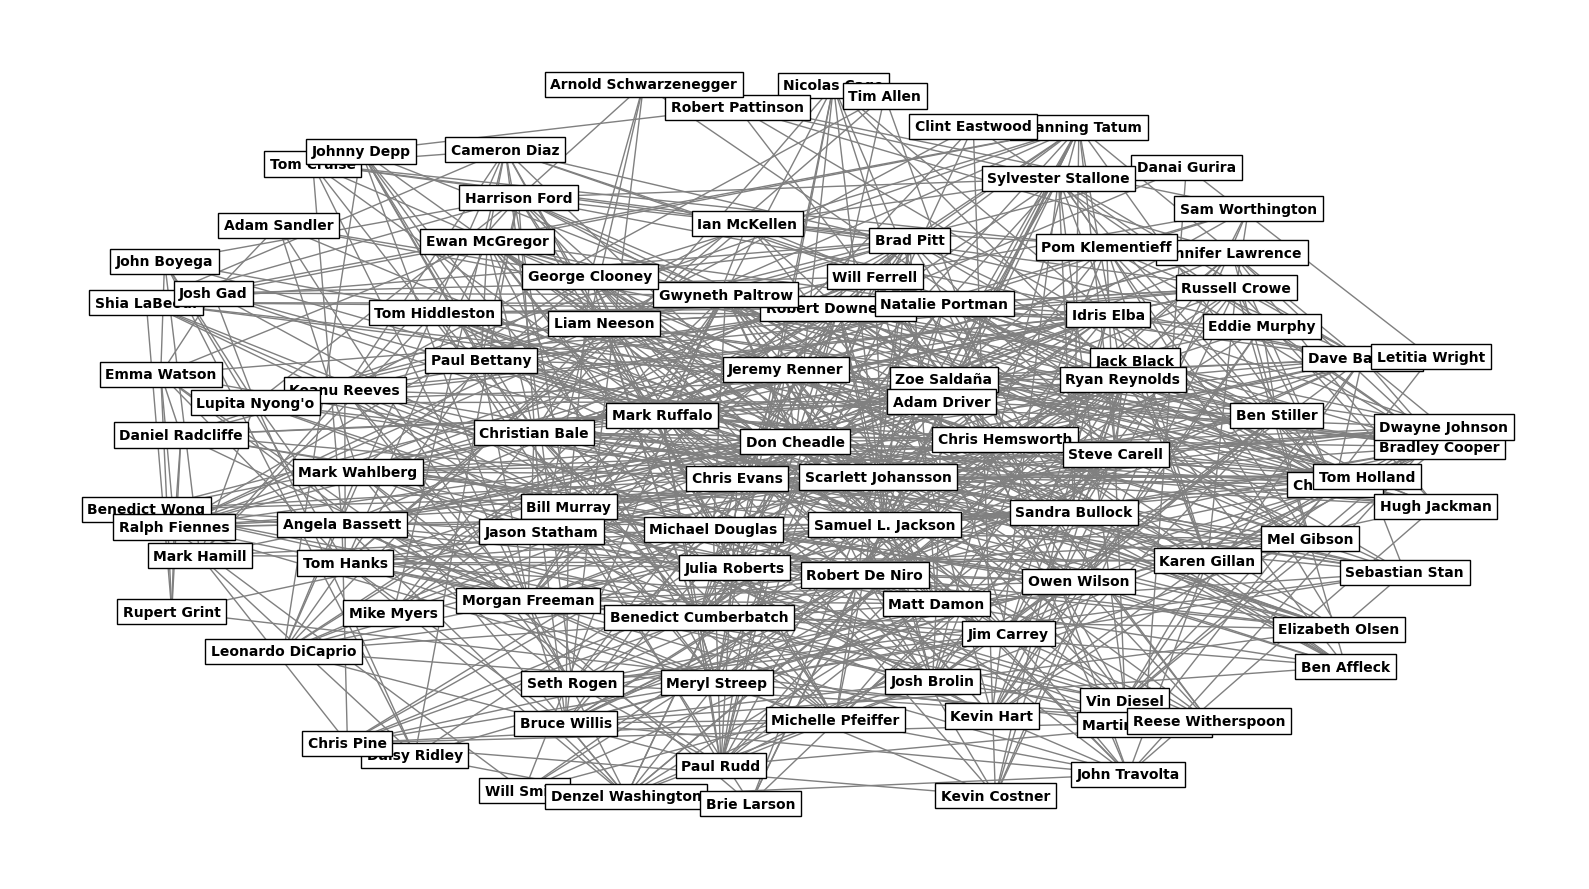

In [369]:
mpl.draw_graph(G_actors,
           seed=50,
           layout="spring",
           node_size=1500,
           node_spacing=13,
           figsize=(16,9),
           node_labels_key="primaryName",
           font_size=10,
           font_weight="bold",
           bbox=dict(facecolor="white"),
           default_edge_style="solid",
           draw_node_shapes=False
           )

In [213]:
mgu = importlib.reload(mgu)
g_actors_cliques_sorted = sorted(nx.find_cliques(G_actors), key=len, reverse=True)
df_g_actors_metrics = mgu.get_graph_metrics_df(G_actors,cliques=g_actors_cliques_sorted,weight_key='weight')

In [214]:
display(df_g_actors_metrics.drop(["Kliky"]))
print("Průměrný nevážený clustering")
display(nx.average_clustering(G_actors))

Počet uzlů,Počet hran,Tranzitivita,Diametr,Hustota,Průměrná délka cesty,Klikovost,Průměrný clustering,Počet artikulací,Počet mostů,Počet komponent,Počet klik,Artikulace,Mosty
i64,i64,f64,i64,f64,f64,i64,f64,i64,i64,i64,i64,list[null],list[null]
100,773,0.282594,4,0.156162,2.006667,9,0.048728,0,0,1,455,[],[]


Průměrný nevážený clustering


0.30149241213313765

Z výše uvedeného lze relativně bezpečně usoudit, že daná síť splňuje vlastnosti malosvětovosti.
- Malý diameter oproti počtu uzlů - log(N) (10) > Diameter (4)
- Velký průměrný nevážený clustering - 0,3
- Velká klikovost a počet klik
- Nízká průměrná délka cesty - 2

Jedná se tedy o hustě propojenou (0,16) síť bez jakýchkoliv mostů či artikulací.

In [370]:
import importlib



mgu = importlib.reload(mgu)
df_g_actors_node_metrics = mgu.get_nodes_metrics_df(
    G_actors,
    g_actors_cliques_sorted,
    attributes=["primaryName"],
    weight_key='weight'
)

#### Herci s nejčastějšími spoluprácemi
K identifikaci herců jež se nejčastěji objevují na plátně spolu s dalšími herci ze 100 nejvýdělečnějších herců
se pro každého herce spočítá relativní četnost filmů v nichž účinkovali i ostatní herci z datasetu ze všech filmů v nichž daný herec hrál.

Relativní četnost pro herce = počet filmů v nichž hrál s ostatními / počet všech filmů v nichž hrál.

Domněnky:
- Vysoká relativní četnost společných filmů může značit preferenci známějších a dražších filmů, jelikož více vysoce výdělečných herců může značit vyšší náklady na daný film.   
    K potvrzení této domněnky by však bylo třeba třeba další analýzy a rozšíření datasetu o cenu jednotlivých filmů. 

- Vysoká četnost může být způsobena i malým počtem odehraných filmů.

- Tato četnost by mohla být vysoká zejména u herců hrajících v filmových seriích v nichž hrají i daší herci z tohoto datasetu.   
    K ověření této myšlenky by bylo znovu nutné rozšíření datasetu, tentokrát o informace do jaké filmové série daný film spadá.



In [216]:
from typing import Iterable
import mylib.data_utils as mdu

film_actor_count = {film:mdu.count(filter(lambda film_neighbor: G.nodes[film_neighbor]["type"] == "actor", G.neighbors(film))) for film in film_nodes}

def shared_film_count(films:Iterable):
    return sum(map(lambda film: 1 if film_actor_count[film] > 1 else  0,films))

actor_shared_film_frequency = { actor: float(shared_film_count(G.neighbors(actor)))/G.degree(actor) for actor in G_actors.nodes }



In [292]:
df_actor_film_frequency = pl.DataFrame({
    "actor":actor_nodes,
    "primaryName":map(lambda actor: G.nodes[actor]["primaryName"],actor_nodes),
    "shared_film_frequency":map(lambda actor:actor_shared_film_frequency[actor],actor_nodes),
    "film_count":map(lambda actor: G.degree(actor),actor_nodes)
    })

In [293]:
mdu = importlib.reload(mdu)
with pl.Config(tbl_rows=17):
    mdu.display_side_by_side(
        ("Informace o relativní četnosti spoluprací herců",df_actor_film_frequency.describe()),
        ("Relativní četnost spoluprací mezi herci",df_actor_film_frequency.sort("shared_film_frequency",descending=True)))

statistic,actor,primaryName,shared_film_frequency,film_count
str,str,str,f64,f64
"""count""","""100""","""100""",100.0,100.0
"""null_count""","""0""","""0""",0.0,0.0
"""mean""",null,null,0.346881,43.6
"""std""",null,null,0.124408,20.368821
"""min""","""nm0000093""","""Adam Driver""",0.113208,6.0
"""25%""",null,null,0.26087,32.0
"""50%""",null,null,0.351351,42.0
"""75%""",null,null,0.411765,52.0
"""max""","""nm5397459""","""Zoe Saldaña""",0.75,109.0


Z výše uvedených tabulek vyplívá, že každý herec si v každém třetím filmu zahraje s jiným hercem z téhož datasetu.

Nejvíce společných filmů s ostatními mají Lupita Nyong'o (~75%), Emma Watson (~72%) a Tom Holland (~70%).
Účast ve velkých filmových sérií přispěl zejména hercům: Emma Watson (Harry Potter), Tom Holland (filmový vesmír od studia Marvel).

Za to nejméně společných filmů s ostatními mají Client EastWood (~11%), Nicolas Cage (~11%) a Adam Sandler (~12%).

Ze zobrazeného výřezu se zdá, že by tu skutečně mohla existovat spojitost mezi počtem odehraných filmů a filmů v nichž hráli s ostaními vybranými herci.  

<Axes: >

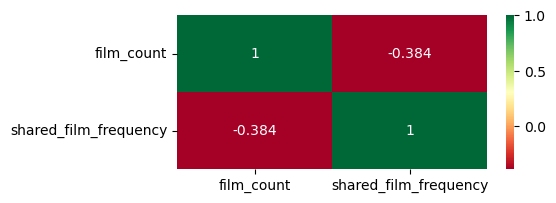

In [294]:
plt.figure(figsize=(5, 2))
sns.heatmap(
    round(df_actor_film_frequency.select(["film_count","shared_film_frequency"]).to_pandas().corr(),3),
    annot=True,
    fmt="g",
    cmap="RdYlGn",
)

Výše lze vidět, že určitá míra negativní korelace mezi počtem filmů a relativní četností sdílených filmů s ostatními tu je.

#### Herci s nejvíce spolupracovníky
Nalezení herců jež spolupracovali s nejvíce nejvýdělečnějšími herci pomocí stupňů vrcholů (degree centrality).

Zjištění herců s největším počtem spoluprací, tedy herců jež hráli s nejvíce ostatními herci.

In [371]:

df_g_actors_node_metrics.describe()

statistic,uzel,klikovost,degree,eigen-vector,betweeness,closeness,clustering,weighted degree,primaryName
str,str,f64,f64,f64,f64,f64,f64,f64,str
"""count""","""100""",100.0,100.0,100.0,100.0,100.0,100.0,100.0,"""100"""
"""null_count""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""0"""
"""mean""",null,16.82,15.46,0.066672,0.010272,0.502984,0.048728,23.68,null
"""std""",null,13.209562,6.791885,0.074906,0.00898,0.046785,0.033036,12.569709,null
"""min""","""nm0000093""",1.0,4.0,0.004106,0.0,0.375,0.0,4.0,"""Adam Driver"""
"""25%""",null,8.0,11.0,0.027249,0.004318,0.482927,0.029307,16.0,null
"""50%""",null,13.0,15.0,0.041693,0.007809,0.512953,0.039595,21.0,null
"""75%""",null,21.0,19.0,0.069583,0.014402,0.532258,0.056727,29.0,null
"""max""","""nm5397459""",78.0,37.0,0.375949,0.049182,0.611111,0.2,72.0,"""Zoe Saldaña"""


Výše si lze všimnout, že maximální klikovost je více než trojnásobná oproti klikovosti 75% herců, toto by mohlo být způsobeno velkými úspěšnými filmy, jež by mohly být součástí filmových sérií.
Stejný efekt ikdyž v menším měřítku lze pozorovat u degree, eigen-vector a betweeness centralit.

Dále stojí za povšimnutí nízká hodnota maximální betweeness centrality, tedy "0,1", což naznačuje, že jde o dobře propojenou síť s velkým počtem duplicitních spojení, tedy zde není herec, jenž by významně oslabil délku nejkratších cest.

Velká closeness centralita u většiny uzlů ukazuje existenci spousty zkratek a velmi dobrou konektivitu v síti.

Hodnoty centralit využívající vzdálenosti, tedy cenu spočítanou dříve, obsahují chybu způsobenou akumulací menších chyb kvůli nepřesné reprezentaci čísel s plovoucí desetinnou čárkou, viz. [Transformace síly spojení na cenu](#transformace-síly-spojení-autorů-na-cenu).

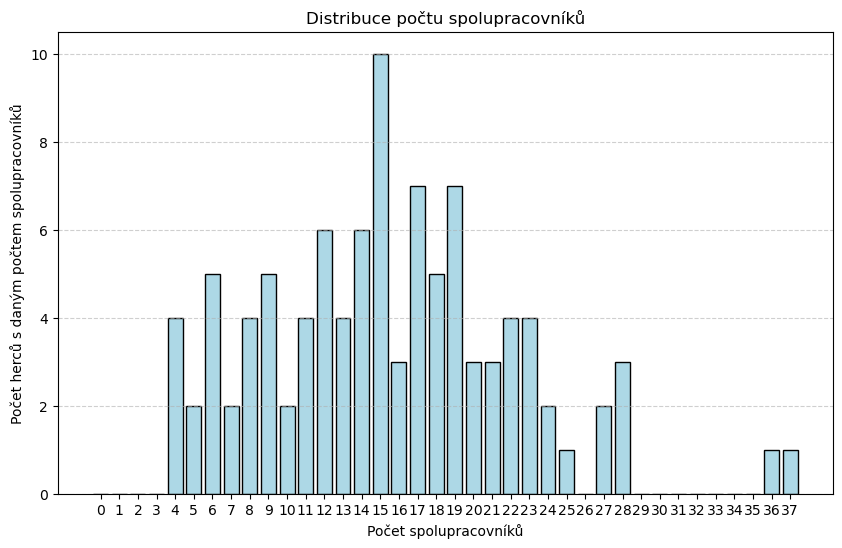

In [221]:
df_g_actors_degree_counts = df_g_actors_node_metrics.select(
    pl.col("degree").value_counts()
    ).unnest("degree").sort(pl.col("degree"))

x, height, ticks = mdu.prepare_degree_data(
    df_g_actors_degree_counts,
    degree_col='degree',
    xtick_step=1  # nebo jiné podle potřeby
)

mpl.plot_bar(
    x=x,
    height=height,
    figsize=(10,6),
    xlabel='Počet spolupracovníků',
    ylabel='Počet herců s daným počtem spolupracovníků',
    title='Distribuce počtu spolupracovníků',
    xticks=ticks
)

Na výše uvedeném grafu lze vidět existenci 2 uzlů s vysokýmí stupni 36 a 37, tito herci tedy spolupracovali s největším počtem ostatních herců.  
Dále tu máme 3 uzly se stupněm 28 a 2 uzly se stupněm 27. 

Nejvíce herců má stupně mezi 12 a 19.

In [372]:
mdu.display_side_by_side(
    ("Herci seřazení dle stupně vrcholu",
     df_g_actors_node_metrics.sort("degree",descending=True).head(10)
     ),
    ("Herci seřazení dle closeness centrality",
     df_g_actors_node_metrics.select(["closeness","degree","primaryName"]).sort("closeness",descending=True).head(10)
     ))

uzel,klikovost,degree,eigen-vector,betweeness,closeness,clustering,weighted degree,primaryName
str,i64,i64,f64,f64,f64,f64,i64,str
"""nm0000168""",66,37,0.224103,0.049182,0.611111,0.03666,62,"""Samuel L. Jackson"""
"""nm0424060""",78,36,0.375949,0.037084,0.611111,0.056727,72,"""Scarlett Johansson"""
"""nm0749263""",34,28,0.283654,0.027038,0.568966,0.05874,53,"""Mark Ruffalo"""
"""nm0000332""",35,28,0.282259,0.023746,0.575581,0.061089,51,"""Don Cheadle"""
"""nm0000288""",46,28,0.08028,0.026972,0.5625,0.029651,32,"""Christian Bale"""
"""nm0000375""",30,27,0.348977,0.030881,0.565714,0.071082,62,"""Robert Downey, Jr."""
"""nm0000134""",50,27,0.063819,0.029678,0.568966,0.034586,41,"""Robert De Niro"""
"""nm0000151""",40,25,0.069227,0.025259,0.5625,0.028301,33,"""Morgan Freeman"""
"""nm0757855""",20,24,0.133107,0.017426,0.55,0.050908,39,"""Zoe Saldaña"""


Z výše uvedené tabulky lze zjistit, že herci s největším počtem spoluprací jsou Samuel L. Jackson a Scarlett Johansson.  
Také si lze povšimnout vysoké klikovosti u obou těchto herců (78 a 62).
Herci s největším počtem spoluprací mají prakticky nejblíže ke všem ostatním jak lze vidět porovnáním výše zmíněných tabulek.
Toto poukazuje na to, že tito herci jsou součástí silně propojeného jádra sítě.



#### Nejvíce spolupracující dvojice

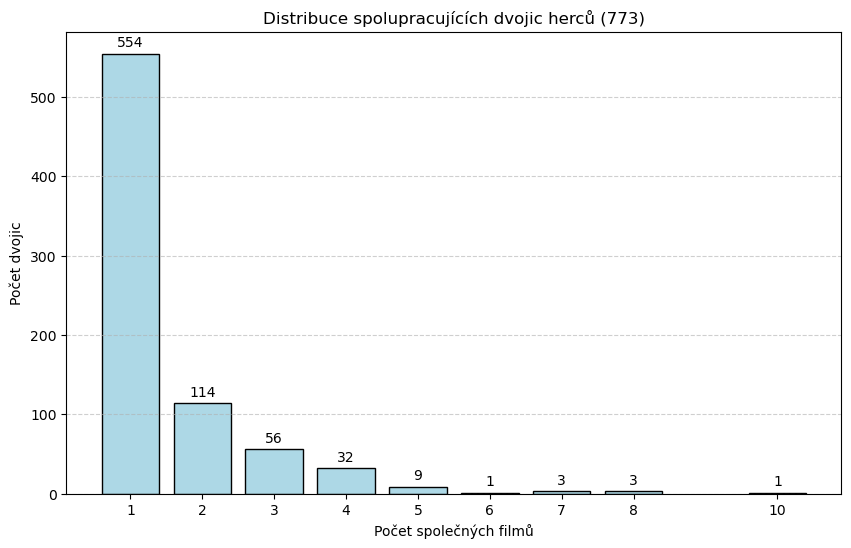

In [277]:
edge_weights = [w for u, v, w in G_actors.edges(data='weight')]

df_weights = pl.DataFrame({"weight": edge_weights})
weight_counts = (
    df_weights.group_by("weight")
    .agg(pl.len().alias("count"))
    .sort("weight")
)

mpl.plot_bar(
    x=weight_counts["weight"].to_list(),
    height=weight_counts["count"].to_list(),
    xlabel="Počet společných filmů",
    ylabel="Počet dvojic",
    title=f"Distribuce spolupracujících dvojic herců ({len(G_actors.edges)})",
    add_labels=True,
    xticks=weight_counts["weight"].to_list()
)

Zde můžeme vidět, že většina herců spolu hrála pouze jednou (554 dvojic ze 773 dvojic).
Dvakrát spolu hrálo pouze 114 dvojic herců.
Máme tu také jednu dvojici jež spolu hrála 10x.
Poté je zde 7 dvojic herců jež spolu hrálo více než 5x, ale méně než 10x.

Část herců jež spolu hráli vícekrát, například 3x a vícekrát spolu pravděpodobně účinkovali v filmových sériích, původní dataset bohužel tyto data neposkytuje, takže bez jeho doplnění, jež je mimo rozsah této práce, není možné získat kolik dvojic spolu spolupracovalo v filmových sériích.

In [291]:
rows = []
for u, v, d in G_actors.edges(data=True):
    shared_movies = set(G.neighbors(u)) & set(G.neighbors(v))
    shared_movie_titles = [G.nodes[m]["primaryTitle"] for m in shared_movies]
    rows.append({
        "herec 1": u,
        "herec 2": v,
        "jméno herce 1": G.nodes[u].get("primaryName"),
        "jméno herce 2": G.nodes[v].get("primaryName"),
        "váha": d.get("weight", 0),
        "filmy":shared_movies,
        "názvy filmů":shared_movie_titles
    })

df_actor_edges = pl.DataFrame(rows)
         

with CFG_PL_FULL_TABLE:
    mdu.display_with_title("Dvojice s nejvíce společnými filmy",df_actor_edges.drop('filmy').sort("váha",descending=True).head(10))

herec 1,herec 2,jméno herce 1,jméno herce 2,váha,názvy filmů
str,str,str,str,i64,list[str]
"""nm0001774""","""nm0005562""","""Ben Stiller""","""Owen Wilson""",10,"[""Meet the Fockers"", ""Night at the Museum: Battle of the Smithsonian"", ""Night at the Museum: Secret of the Tomb"", ""Starsky & Hutch"", ""Little Fockers"", ""Permanent Midnight"", ""Meet the Parents"", ""The Royal Tenenbaums"", ""Zoolander"", ""Zoolander 2""]"
"""nm0914612""","""nm0705356""","""Emma Watson""","""Daniel Radcliffe""",8,"[""Harry Potter and the Order of the Phoenix"", ""Harry Potter and the Goblet of Fire"", ""Harry Potter and the Prisoner of Azkaban"", ""Harry Potter and the Deathly Hallows: Part 1"", ""Harry Potter and the Deathly Hallows: Part 2"", ""Harry Potter and the Sorcerer's Stone"", ""Harry Potter and the Half-Blood Prince"", ""Harry Potter and the Chamber of Secrets""]"
"""nm0914612""","""nm0342488""","""Emma Watson""","""Rupert Grint""",8,"[""Harry Potter and the Order of the Phoenix"", ""Harry Potter and the Goblet of Fire"", ""Harry Potter and the Prisoner of Azkaban"", ""Harry Potter and the Deathly Hallows: Part 1"", ""Harry Potter and the Deathly Hallows: Part 2"", ""Harry Potter and the Sorcerer's Stone"", ""Harry Potter and the Half-Blood Prince"", ""Harry Potter and the Chamber of Secrets""]"
"""nm0705356""","""nm0342488""","""Daniel Radcliffe""","""Rupert Grint""",8,"[""Harry Potter and the Order of the Phoenix"", ""Harry Potter and the Goblet of Fire"", ""Harry Potter and the Prisoner of Azkaban"", ""Harry Potter and the Deathly Hallows: Part 1"", ""Harry Potter and the Deathly Hallows: Part 2"", ""Harry Potter and the Sorcerer's Stone"", ""Harry Potter and the Half-Blood Prince"", ""Harry Potter and the Chamber of Secrets""]"
"""nm0424060""","""nm0000375""","""Scarlett Johansson""","""Robert Downey, Jr.""",7,"[""Avengers: Infinity War"", ""Avengers: Age of Ultron"", ""Captain America: Civil War"", ""The Avengers"", ""Iron Man 2"", ""Avengers: Endgame"", ""Chef""]"
"""nm0424060""","""nm0262635""","""Scarlett Johansson""","""Chris Evans""",7,"[""Avengers: Infinity War"", ""Captain America: Civil War"", ""Avengers: Age of Ultron"", ""Captain America: The Winter Soldier"", ""The Perfect Score"", ""Avengers: Endgame"", ""The Avengers""]"
"""nm0000354""","""nm0000255""","""Matt Damon""","""Ben Affleck""",7,"[""Chasing Amy"", ""Air"", ""School Ties"", ""The Third Wheel"", ""Dogma"", ""The Last Duel"", ""Good Will Hunting""]"
"""nm0000375""","""nm0000332""","""Robert Downey, Jr.""","""Don Cheadle""",6,"[""Avengers: Infinity War"", ""Avengers: Age of Ultron"", ""Captain America: Civil War"", ""Iron Man 2"", ""Avengers: Endgame"", ""Iron Man 3""]"
"""nm0000168""","""nm0488953""","""Samuel L. Jackson""","""Brie Larson""",5,"[""Unicorn Store"", ""The Marvels"", ""Captain Marvel"", ""Farce of the Penguins"", ""Kong: Skull Island""]"


Už jen z těchto pár dvojic jež spolu hráli v nejvíce filmech lze jasně vidět účinek velkých filmových sérií jako jsou "Harry Potter" či filmový vesmír od Marvelu na počet společných filmů těchto herců,  

Zde si lze všimnout, že první příčky zaujímají Ben Stiller a Owen Wilson, jež spolu hráli 10x, z toho 2x v sérii Night at Museum, 2x v sérii Zoolander a 3x v sérii Meet the Parents, tedy spolu hráli v 6 nezávislých filmových projektech: "Starsky & Hutch", "Permanent Midnight", "Night at Museum series (2x)", "Zoolander series (2x)", "Meet the Parents series (3x)","The Royal Tenenbaums".

Všechny dvojice hrající spolu v 8 filmech jsou součástí trojice hlavních hrdinů v sérii "Harry Potter", což je také jediný film v němž spolu hráli dle datasetu. 

V 7 filmech spolu hráli dvojice ("Scarlett Johansson", "Robert Downey Jr."), jež spolu hráli pouze v jednom jediném filmu jenže není součástí filmového vesmíru od Marvelu a to ve filmu "Chef".

Poté je zde další výjimečná dvojice ("Matt Damon", "Ben Affleck") jež spolu hrála pouze v jednom fikčním vesmíru "View Askewniverse" ("Chasing Amy", "Dogma"), s 6 zbylými filmy si společně zahráli v 7 nezávislých filmových projektech.

Na dalších příčkách má podíl hlavně Marvel.
Menší vyjímkou je dvojice ("Samuel L. Jackson", "Brie Larson"), jež spolu hrála v celkem 4 nezávislých filmových projektech z toho pouze ve 2 filmech filmového vesmíru od studia Marvel, zbylé 3 filmy z pěti nejsou součástí žádné série.

#### Herci s nejvíce spoluprácemi
Nalezení herců s největším počtem spoluprací.
Tito herci se budou pravděpodobně hodně překrývat s [herci s nejvíce spolupracovníky](#herci-s-nejvíce-spolupracovníky).

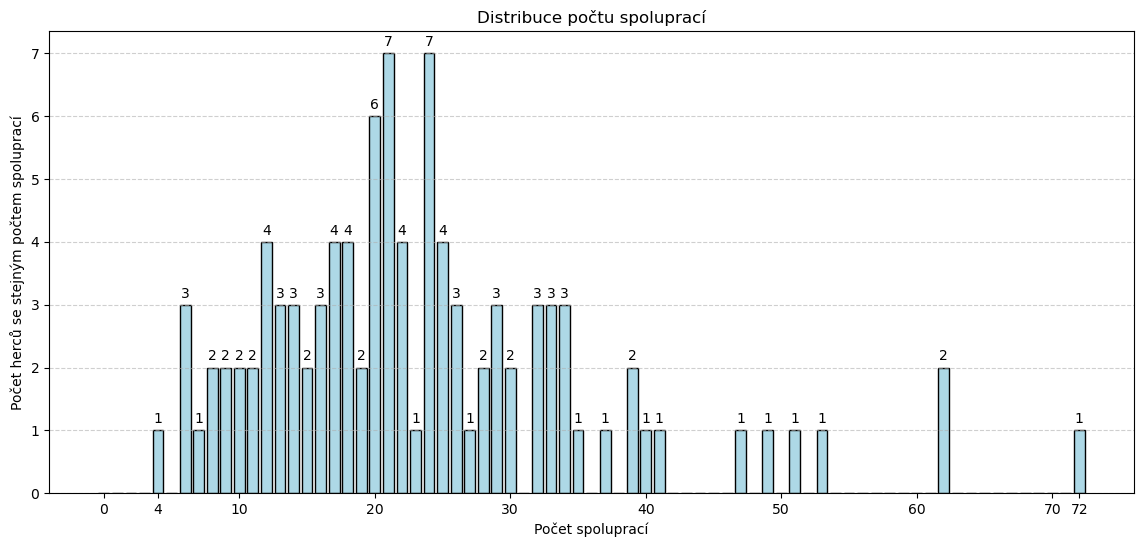

In [225]:
df_g_actors_weighted_degree_counts = df_g_actors_node_metrics.select(
    pl.col("weighted degree").value_counts()
    ).unnest("weighted degree").sort(pl.col("weighted degree"))

x, height, ticks = mdu.prepare_degree_data(
    df_g_actors_weighted_degree_counts,
    degree_col='weighted degree',
    xtick_step=10
)

mpl.plot_bar(
    x=x,
    height=height,
    figsize=(14, 6),
    xlabel='Počet spoluprací',
    ylabel='Počet herců se stejným počtem spoluprací',
    title='Distribuce počtu spoluprací',
    add_labels=True,
    xticks=ticks
)

Výše lze vidět, podobnou sktrukturu jako u herců s nejvíce spolupracovníky, avšak zde je větší maximální hodnota a je tu více herců s nadprůměrným počtem spoluprací.

In [286]:
mdu.display_with_title("Herci seřazení dle počtu spoluprací",
     df_g_actors_node_metrics.sort('weighted degree',descending=True).head(10)
    )
mdu.display_side_by_side(
    ("Herci seřazení dle počtu spoluprací",
     df_g_actors_node_metrics.select(["uzel","primaryName","degree","weighted degree"])\
         .sort('weighted degree',descending=True).head(10)
     ),
    ("Herci seřazení dle počtu spolupracovníků",
     df_g_actors_node_metrics.select(["degree","weighted degree","primaryName"])\
         .sort("degree",descending=True).head(10)
     ))

uzel,klikovost,degree,eigen-vector,betweeness,closeness,clustering,weighted degree,primaryName
str,i64,i64,f64,f64,f64,f64,i64,str
"""nm0424060""",78,36,0.375949,0.037084,0.611111,0.056727,72,"""Scarlett Johansson"""
"""nm0000168""",66,37,0.224103,0.049182,0.611111,0.03666,62,"""Samuel L. Jackson"""
"""nm0000375""",30,27,0.348977,0.030881,0.565714,0.071082,62,"""Robert Downey, Jr."""
"""nm0749263""",34,28,0.283654,0.027038,0.568966,0.05874,53,"""Mark Ruffalo"""
"""nm0000332""",35,28,0.282259,0.023746,0.575581,0.061089,51,"""Don Cheadle"""
"""nm0262635""",21,20,0.311756,0.007792,0.535135,0.113319,49,"""Chris Evans"""
"""nm1165110""",23,19,0.282735,0.004176,0.532258,0.123965,47,"""Chris Hemsworth"""
"""nm0000134""",50,27,0.063819,0.029678,0.568966,0.034586,41,"""Robert De Niro"""
"""nm0719637""",20,22,0.236534,0.010754,0.540984,0.074071,40,"""Jeremy Renner"""


uzel,primaryName,degree,weighted degree
str,str,i64,i64
"""nm0424060""","""Scarlett Johansson""",36,72
"""nm0000168""","""Samuel L. Jackson""",37,62
"""nm0000375""","""Robert Downey, Jr.""",27,62
"""nm0749263""","""Mark Ruffalo""",28,53
"""nm0000332""","""Don Cheadle""",28,51
"""nm0262635""","""Chris Evans""",20,49
"""nm1165110""","""Chris Hemsworth""",19,47
"""nm0000134""","""Robert De Niro""",27,41
"""nm0719637""","""Jeremy Renner""",22,40


"Scarlett Johansson" má nejvíce spoluprací ze všech herců.
Za ní tentokrát následuje "Samuel L. Jackson" a "Robert Downey Jr.", jež jsou o 10 spoluprací za "Scarlett Johansson". Největší rozdíly jsou asi u herce jménem "Robert Downey Jr.", jež se díky velké četnosti spoluprací (Marvel) dostal na druhé místo. 

Poté u herce "Christian Bale", jež sice spolupracoval s mnoha herci ale většinou pouze jednou a tudíž z tabulky úplně zmizel. 

Následně je zde opačný případ v podobě herců "Chris Evans" a "Chris Hemsworth" jež sice spolupracovali pouze s 19 herci a 20 herci, ale spolupracovali s nimi mnohokrát (Marvel).

I zde je vidět velký vliv minimálně jedné rozsáhlé filmové série, v tomto případě filmový vesmír od studia Marvel.

#### Shrnutí
Byla analyzována síť herců v níž jsou herci spojeni hranou v případě účinkování ve stejném filmu, váha hrany určuje počet těchto společných filmů.

Byly zjištěni dva nejdůležitější herci z pohledu společných filmů a to Samuel L. Jackson a Scarlett Johansson.
Tito herci hráli s nejvíce ostatními herci a také měli nejvíce spoluprací.

Dále byli zjišteni herci jež ve více než v 70% filmů účinkovali po boku dalších herců z datasetu: Lupita Nyong'o, Emma Watsona Tom Holland.

Nalezli se herci nacházející se uprostřed sítě: Samuel L. Jackson a Scarlett Johansson.  
Poté se nalezli herci jež nejvícekrát hráli po boku jiného herce: Scarlett Johansson, Samuel L. Jackson a Robert Downey, Jr.

Kromě nich byly identifikovány dvojice s největším počtem filmů: Ben Stiller a Owen Wilson, hlavní trojice z filmové série Harry Potter (Daniel Radcliffe, Emma Watson a Rupert Grint).
Zde byl nejvíce patrný vliv velkých filmových sérií (hlavně Harry Potter a filmový vesmír od studia Marvel).


### Analýza projekce žánrů

#### Slovník pojmů
- Nejkombinovatelnější žánr - žánr sdílící alespoň jeden společný film s co největším počtem žánrů. Jedná se tedy o žánr s maximální kombinační šíří.
- Nejpopolárnější žánr - žánr s největším počtem zastoupení ve filmech bez ohledu na jeho kombinovatelnost.
- Žánr s největším kombinačním objemem - žánr vyskytující se v největším celkovém počtu žánrových kombinací napříč filmy.

#### Předběžná analýza

In [339]:
mgu=importlib.reload(mgu)
import mylib.graph_utils as mgu
G_genres = nxbp.weighted_projected_graph(
    G.subgraph(genre_nodes+film_nodes),
    genre_nodes)

In [341]:
df_g_genres_metrics = mgu.get_graph_metrics_df(G_genres,weight_key='weight')

In [342]:
display(df_g_genres_metrics.drop("Kliky"))

Počet uzlů,Počet hran,Tranzitivita,Diametr,Hustota,Průměrná délka cesty,Klikovost,Průměrný clustering,Počet artikulací,Počet mostů,Počet komponent,Počet klik,Artikulace,Mosty
i64,i64,f64,i64,f64,f64,i64,f64,i64,i64,i64,i64,list[null],list[null]
23,163,0.772538,3,0.644269,1.379447,11,0.042171,0,0,1,35,[],[]


Z výše uvedeného tabulky se jedná o velmi hustou síť bez jakýchkoli artikulací či mostů a
s maximálním délkou cesty 3.

In [343]:
g_genres_cliques_sorted = sorted(nx.find_cliques(G_genres), key=len, reverse=True)
df_g_genres_node_metrics = mgu.get_nodes_metrics_df(G_genres,g_genres_cliques_sorted,weight_key='weight')

In [344]:
display(df_g_genres_node_metrics.describe())

statistic,uzel,klikovost,degree,eigen-vector,betweeness,closeness,clustering,weighted degree
str,str,f64,f64,f64,f64,f64,f64,f64
"""count""","""23""",23.0,23.0,23.0,23.0,23.0,23.0,23.0
"""null_count""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",null,13.086957,14.173913,0.14319,0.018069,0.745313,0.042171,674.0
"""std""",null,10.242128,4.754445,0.154981,0.018773,0.118225,0.027263,793.54521
"""min""","""Action""",1.0,2.0,0.000031,0.0,0.468085,0.005294,2.0
"""25%""",null,5.0,13.0,0.037725,0.005307,0.709677,0.021263,161.0
"""50%""",null,11.0,15.0,0.075533,0.010645,0.758621,0.038417,341.0
"""75%""",null,20.0,18.0,0.25227,0.028494,0.846154,0.055687,1002.0
"""max""","""Western""",33.0,20.0,0.519574,0.082328,0.916667,0.103202,3023.0


Z výše zmíněné tabulky lze zjistit, že 75% žánrů má 4x vyšší stupeň než žánr s nejnižším stupněm, což poukazuje na málo kombinovaný žánr. 
Zároveň je zde také žánr se stupněm 20, jenž nebyl zkombinován pouze se dvěma dalšími žánry.

Dále tu lze vidět v podstatě stejný rozdíl v eigen-vector centralitě, žánr s takto nízkou eigen-vector centralitou bude pravděpodobně žánr jenž se nekombinuje s žádným kombinovatelnějším žánrem.

Většina žánrů je dobře kombinovatelná, 75% žánrů je kombinovatelných s ~62% dalšími žánry.

#### Nejpopulárnější žánr
Nejpopulárnější žánr má největší filmové zastoupení ze všech žánrů.

Předpoklady:
- Nejpopulárnější žánr bude spíše podpůrný, tedy pravděpodobně nepůjde o žánr striktně specifikující čas či typ děje.

In [345]:
df_genre_film_count = pl.DataFrame(list(map(
    lambda node_and_film_count: (*node_and_film_count,node_and_film_count[1]/len(film_nodes)),G.degree(genre_nodes)
                                        )),
                                   schema=["Genre","Film count","Relative film count"],
                                   orient="row"
                                   )

In [346]:
with CFG_PL_ALL_ROWS:
    mdu.display_side_by_side(("Informace o žánrech a počtu jejch použití",
                              df_genre_film_count.describe()
                              ),
                             ("Žánry seřazené dle počtu použití",
                              df_genre_film_count.sort("Film count",descending=True)
                              ))

statistic,Genre,Film count,Relative film count
str,str,f64,f64
"""count""","""23""",23.0,23.0
"""null_count""","""0""",0.0,0.0
"""mean""",null,391.913043,0.110429
"""std""",null,480.288636,0.135331
"""min""","""Action""",1.0,0.000282
"""25%""",null,104.0,0.029304
"""50%""",null,173.0,0.048746
"""75%""",null,586.0,0.165117
"""max""","""Western""",1914.0,0.539307


Z výše zmíněných tabulek lze snadno identifikovat nejpopulárnější žánr napříč datasetem (Drama ~54%).
Z 23 žánrů se zde nacházejí 3 žánry jejichž kombinaci má více než 25% všech filmů - Drama, Comedy a Action.

První trojici žánrů tedy tvoří podpůrné žánry a většina žánrů s užším vymezením má také nižší zastoupení.

Poté lze ještě identifikovat 7 prvních žánrů jež mají nadprůměrné zastoupení napříč filmy (nad ~11%).
Další žánr v pořadí má poloviční zastoupení (Mystery 8% oproti Romance ~16%).

Polovina žánrů má zastoupení pod ~4%.

Nachází se zde tedy relativně malá skupinka velice populárních žánrů, většina žánrů (~70%) má zastoupení mezi filmy ne větší než 8%.

Nejméně zastoupenými žánry jsou News (1 film) a Reality-TV (4 filmy).



#### Nejkombinovatelnější žánr
Nejkombinovatelnější žánr je žánr, jenž se kombinuje s co největším počtem ostatních žánrů.
Dal by se tedy nazvat i doplňkovým žánrem, jelikož ho lze přidat prakticky k jakémukoli jinému žánru.
Je to tedy žánr jenž má spojení s největším počtem ostatních žánrů, neboli žánr s nejvyšším stupněm.

In [347]:
df_g_genres_degree_counts = df_g_genres_node_metrics.select(
    pl.col("degree").value_counts()
    ).unnest("degree").sort(pl.col("degree"))

max_deg = df_g_genres_degree_counts['degree'].max()

full_degrees = pl.DataFrame({"degree": list(range(0, max_deg + 1))})

full_counts = full_degrees.join(
    df_g_genres_degree_counts, on="degree", how="left"
).fill_null(0)

In [354]:
mdu.display_with_title("Imformace o kombinovatelnosti žánrů",
                       df_g_genres_node_metrics.select("degree").describe())

statistic,degree
str,f64
"""count""",23.0
"""null_count""",0.0
"""mean""",14.173913
"""std""",4.754445
"""min""",2.0
"""25%""",13.0
"""50%""",15.0
"""75%""",18.0
"""max""",20.0


Z tabulky vyplívá, že průměrný počet kombinovatelných žánrů je pro každý žánr okolo 14.

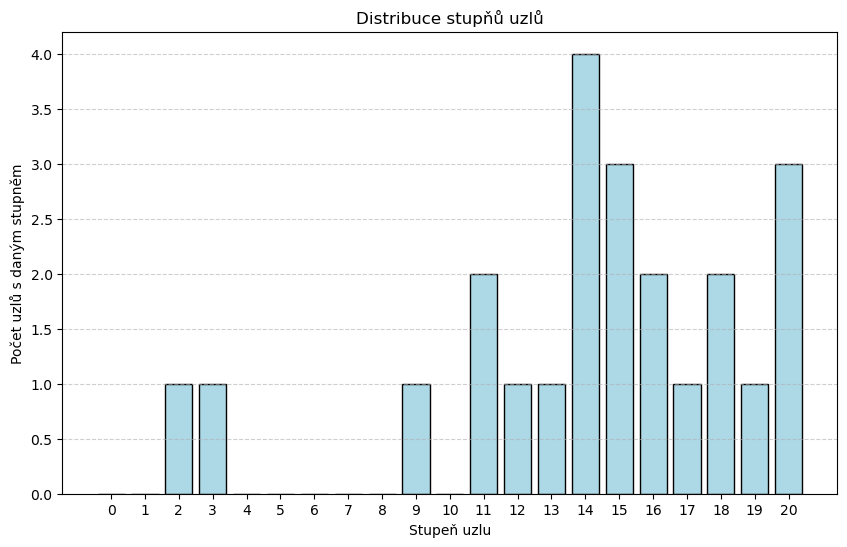

In [351]:
mpl.plot_bar(
    x=full_counts['degree'].to_list(),
    height=full_counts['count'].to_list(),
    xlabel="Stupeň uzlu",
    ylabel="Počet uzlů s daným stupněm",
    title="Distribuce stupňů uzlů",
    xticks=range(full_counts.height)
)


Jak vyplívá z grafu, nachází se zde dva žánry se stupni 2 a 3, což poukazuje na speciální špatně kombinovatelné žánry.

Jsou tu 3 žánry se stupněm 20, 1 žánr se stupněm 19 a 6 žánrů se stupněm 16, 17 nebo 18.

Žánry se stupněm 20 nejsou kombinovatelné pouze s dalšími 2 žánry.

In [355]:
genres_set = set(G_genres.nodes())
genres_neighbors_dict = {node:set(G_genres.neighbors(node)) for node in G_genres.nodes()}
genres_neighbors_list_dict = {node:list(G_genres.neighbors(node)) for node in G_genres.nodes()}
genres_not_neigbors_dict = {node:((genres_set-neigbors)-{node}) for node,neigbors in genres_neighbors_dict.items()}
genres_not_neigbors_list_dict = {node:list(genres_set-neigbors-{node}) for node,neigbors in genres_neighbors_dict.items()}
df_g_genres_node_metrics_extended = df_g_genres_node_metrics.with_columns(
    pl.col("uzel").replace_strict(genres_not_neigbors_list_dict).alias("nekombinované"),
    pl.col("uzel").replace_strict(genres_neighbors_list_dict).alias("kombinované"),
)

In [359]:
with CFG_PL_FULL_ROWS:
    mdu.display_with_title("Informace o žánrech seřazených dle kombinovatelnosti",
        df_g_genres_node_metrics_extended.drop("kombinované").sort("degree",descending=True).head(10))

uzel,klikovost,degree,eigen-vector,betweeness,closeness,clustering,weighted degree,nekombinované
str,i64,i64,f64,f64,f64,f64,i64,list[str]
"""Comedy""",33,20,0.418067,0.028494,0.916667,0.079337,2053,"[""News"", ""Reality-TV""]"
"""Drama""",33,20,0.519574,0.028494,0.916667,0.103202,3023,"[""News"", ""Reality-TV""]"
"""Adventure""",33,20,0.268886,0.028494,0.916667,0.055341,1326,"[""News"", ""Reality-TV""]"
"""Action""",24,19,0.393565,0.023715,0.88,0.078887,1929,"[""Documentary"", ""News"", ""Reality-TV""]"
"""Romance""",20,18,0.25227,0.019872,0.846154,0.048835,932,"[""Animation"", ""Documentary"", ""News"", ""Reality-TV""]"
"""Crime""",23,18,0.368583,0.018281,0.846154,0.068432,1490,"[""Western"", ""War"", ""News"", ""Reality-TV""]"
"""Biography""",20,17,0.121406,0.018085,0.814815,0.035043,515,"[""Reality-TV"", ""News"", ""Horror"", ""Sci-Fi"", ""Fantasy""]"
"""History""",12,16,0.052859,0.039264,0.785714,0.021263,247,"[""Reality-TV"", ""Music"", ""Horror"", ""Sport"", ""Sci-Fi"", ""Musical""]"
"""Family""",14,16,0.052765,0.035233,0.785714,0.024652,252,"[""Reality-TV"", ""Western"", ""War"", ""Horror"", ""Thriller"", ""Musical""]"


Nejkombinovatelnějšími žánry jsou "Drama", "Comedy" a "Adventure" ikdyž ani "Action" za nimi moc nezaostává.  
První trojice žánrů se nekombinuje pouze s "News" a "Reality-TV" žánry, s nimiž se nekombinuje většina velmi dobře kombinovatelných žánrů.

In [361]:
with CFG_PL_FULL_ROWS:
    mdu.display_with_title("Informace o žánrech seřazených dle kombinovatelnosti",
    df_g_genres_node_metrics_extended.drop("nekombinované").sort("degree",descending=False).head(7))

uzel,klikovost,degree,eigen-vector,betweeness,closeness,clustering,weighted degree,kombinované
str,i64,i64,f64,f64,f64,f64,i64,list[str]
"""Reality-TV""",1,2,0.000031,0.0,0.468085,0.005294,2,"[""Sport"", ""Documentary""]"
"""News""",1,3,0.000129,0.0,0.52381,0.006332,7,"[""History"", ""Family"", ""Documentary""]"
"""Western""",2,9,0.016758,0.001189,0.611111,0.02004,58,"[""Comedy"", ""Romance"", ""History"", ""Drama"", ""War"", ""Action"", ""Biography"", ""Musical"", ""Adventure""]"
"""Musical""",4,11,0.011433,0.004084,0.628571,0.01542,48,"[""Comedy"", ""Romance"", ""Western"", ""Drama"", ""Adventure"", ""Action"", ""Crime"", ""Animation"", ""Music"", ""Horror"", ""Biography""]"
"""Sport""",5,11,0.037725,0.035179,0.666667,0.029795,161,"[""Comedy"", ""Romance"", ""Drama"", ""War"", ""Adventure"", ""Action"", ""Crime"", ""Family"", ""Reality-TV"", ""Biography"", ""Documentary""]"
"""Animation""",5,12,0.075533,0.006029,0.6875,0.038417,341,"[""Comedy"", ""Fantasy"", ""Drama"", ""Adventure"", ""Action"", ""Crime"", ""History"", ""Musical"", ""Family"", ""Biography"", ""Sci-Fi"", ""Documentary""]"
"""Horror""",5,13,0.046452,0.006018,0.709677,0.042697,251,"[""Comedy"", ""Fantasy"", ""Romance"", ""Drama"", ""Adventure"", ""Action"", ""Crime"", ""Thriller"", ""Musical"", ""Mystery"", ""Sci-Fi"", ""Music"", ""Documentary""]"


Nejméně kombinovatelným žánrem je žánr "Reality-TV", jenž se kominuje pouze s žánry "Sport" a "Documentary".
Za ním je žánr "News" jež se kombinuje pouze s "Documentary", "History" a "Family".

Dalšími hůře kombinovatelnými žánry jsou "Western", "Sport", "Musical" a "Animation", jež mají nižší kombinovatelnost než 75% ostatních žánrů.

#### Nejkombinovanější dvojice žánrů

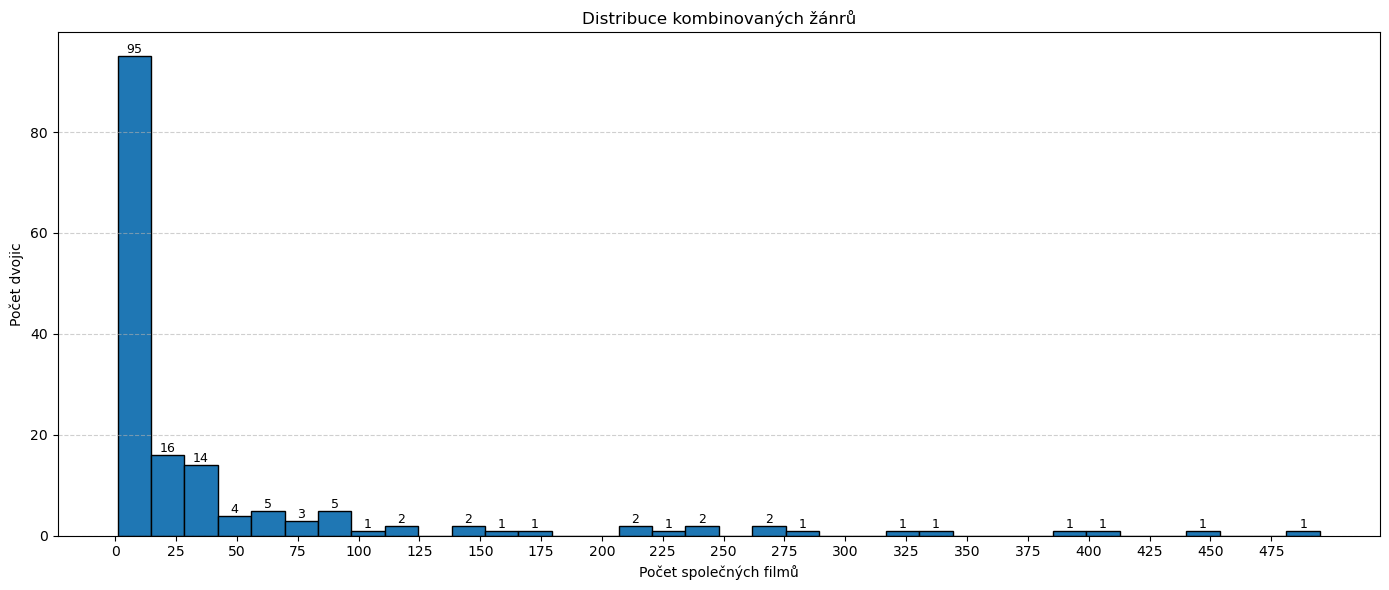

In [363]:
genre_edge_weights = edge_weights = [w for u, v, w in G_genres.edges(data='weight')]
arr = np.array(genre_edge_weights)

# Freedman–Diaconis rule
q25, q75 = np.percentile(arr, [25, 75])
iqr = q75 - q25

bin_width = 2 * iqr / (len(arr) ** (1/3))
if bin_width == 0:
    bin_width = 1

bins = int((arr.max() - arr.min()) / bin_width)
bins = max(bins, 10)

# Plot
fig, ax = plt.subplots(figsize=(14, 6))

n, bins_edges, patches = ax.hist(arr, bins=bins, edgecolor='black')

ax.set_xlabel('Počet společných filmů')
ax.set_ylabel('Počet dvojic')
ax.set_title('Distribuce kombinovaných žánrů')
ax.grid(axis='y', linestyle='--', alpha=0.6)

# --- ADD LABELS ---
for count, patch in zip(n, patches):
    if count > 0:
        x = patch.get_x() + patch.get_width() / 2
        y = patch.get_height()
        ax.text(
            x, y,
            f"{int(count)}",
            ha='center', va='bottom',
            fontsize=9
        )
min_x = bins_edges[0]
max_x = bins_edges[-1]
ax.set_xticks(np.arange(int(min_x/25)*25, max_x + 1, 25))
plt.tight_layout()
plt.show()

Většina dvojic žánrů byla použita z 3503 filmů v méně než 25 (<1%) filmech.
Avšak je tu i dvojice jež byla použita u více než 475 filmech, což je více než 13,5% všech vybraných filmů.

In [367]:
df_genre_edges = pl.DataFrame(
    map(lambda row: ({
    "žánr 1": row[0],
        "žánr 2": row[1],
        "počet filmů": row[2],
        "počet filmů v %":row[2]/len(film_nodes)*100
    }),
    G_genres.edges(data="weight")
    )
)

with CFG_PL_ALL_ROWS:
    mdu.display_with_title("Dvojice žánrů seřazené dle počtu flmů",
        df_genre_edges.sort("počet filmů",descending=True).head(12))

žánr 1,žánr 2,počet filmů,počet filmů v %
str,str,i64,f64
"""Comedy""","""Drama""",495,13.947591
"""Drama""","""Crime""",450,12.679628
"""Romance""","""Drama""",404,11.383488
"""Adventure""","""Action""",393,11.073542
"""Action""","""Crime""",344,9.692871
"""Comedy""","""Romance""",317,8.932094
"""Drama""","""Action""",289,8.143139
"""Action""","""Thriller""",269,7.5796
"""Comedy""","""Adventure""",262,7.382361


Nejkombinovanější dvojicí žánrů je "Drama" a "Comedy", tuto dvojici má skoro 14% filmů.
První tři příčky patří žánru "Drama" a dalším žánrům, poté zde máme na 4. místě dvojici žánrů "Action" a "Adventure", jíž má 11% filmů.